In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [4]:
# class Mynetwork(nn.Module):
#     def __init__(self,input_num=1 , out_num=1,hidden_num=128):
#         super().__init__()
#         self.MLP=nn.Sequential(
#             nn.Linear(input_num, hidden_num),
#             nn.ELU(),
#             nn.Linear(hidden_num,hidden_num),
#             nn.ELU(),
#             nn.Linear(hidden_num,hidden_num),
#             nn.ELU(),
#             nn.Linear(hidden_num,hidden_num),
#             nn.ELU(),
#             nn.Linear(hidden_num,out_num),
#         )
#         pass
#     def forward(self,x):
#         return self.MLP(x)

In [5]:
layer_num=4
hidden_num=128

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)
    

In [6]:
def potential(x):
    poten=-10/x-10*torch.sin(torch.pi*x/24)/x
    return poten

In [7]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=50
extend_num=0
epoch=120000
lr=0.01
# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


In [8]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=180,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    V_diag_real=potential(grid)
    
    rela=V_diag/V_diag_real
    ones=torch.ones_like(rela,device=device)
    
    w=0
    
    k=1
    
    val_loss=k*loss_fn(V_diag,V_diag_real)+w*loss_fn(rela,ones)
    val_loss.backward()
    optimizer.step()
    
    loss_list.append(val_loss.item())
    
    if i%10==0:
        # clear_output(wait=True)
        print(f'epoch:{i},val_loss:{val_loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    scheduler.step(val_loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)


epoch:0,val_loss:1.0163438320159912,time:0.25301361083984375,lr:0.01
epoch:10,val_loss:0.8726654052734375,time:0.2863168716430664,lr:0.01
epoch:20,val_loss:0.7086618542671204,time:0.31821560859680176,lr:0.01
epoch:30,val_loss:0.5944805145263672,time:0.34926271438598633,lr:0.01
epoch:40,val_loss:0.4978736937046051,time:0.381040096282959,lr:0.01
epoch:50,val_loss:0.44900885224342346,time:0.4126589298248291,lr:0.01
epoch:60,val_loss:0.4134235382080078,time:0.4443776607513428,lr:0.01
epoch:70,val_loss:0.35463470220565796,time:0.4774658679962158,lr:0.01
epoch:80,val_loss:0.3215899169445038,time:0.5106124877929688,lr:0.01
epoch:90,val_loss:0.2912658452987671,time:0.5417885780334473,lr:0.01
epoch:100,val_loss:0.2844364047050476,time:0.5730900764465332,lr:0.01
epoch:110,val_loss:0.2995491921901703,time:0.6047272682189941,lr:0.01
epoch:120,val_loss:0.25442570447921753,time:0.6366288661956787,lr:0.01
epoch:130,val_loss:0.2699968218803406,time:0.66983962059021,lr:0.01
epoch:140,val_loss:0.2471826

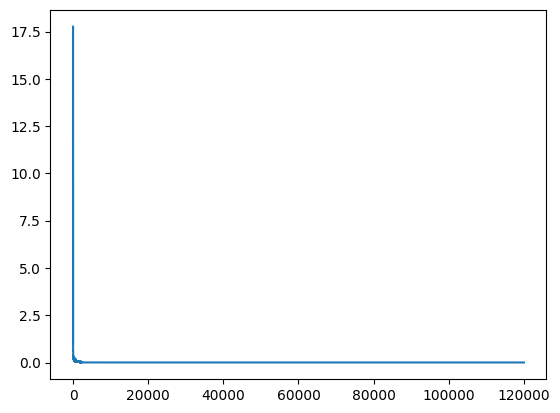

In [9]:
plt.plot(loss_list)
plt.show()

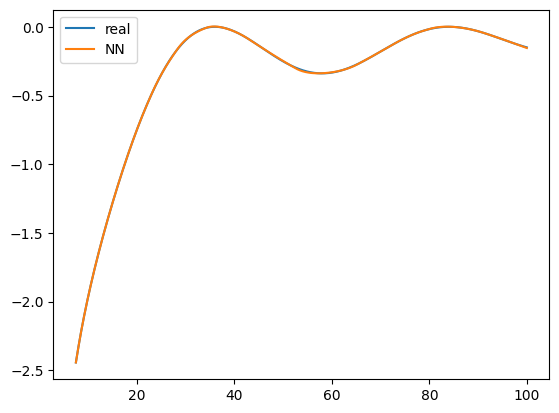

In [10]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[300:-1].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid)
real_poten=real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

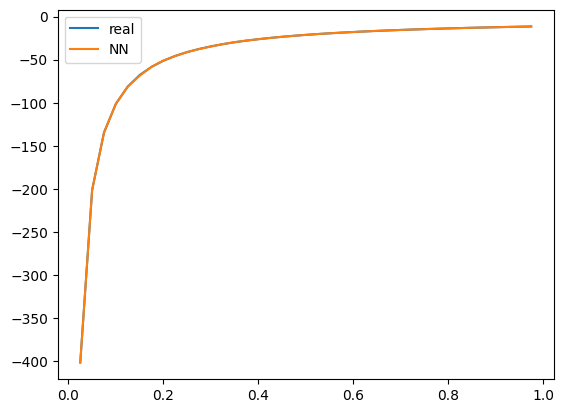

In [11]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:40].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid)
real_poten=real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [12]:
os.makedirs(f'./potential_NN', exist_ok=True)
torch.save(model.state_dict(), f'./potential_NN/potential_NN_f6_1.pt')

In [13]:
# os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
# torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

In [14]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 0.048414525
max_error: 0.7930298
